In [1]:
from fastai.vision.all import *
from casurv.survival.all import *

In [2]:
exp_path = 'tcga_model'
# This path should contain the model
!tree {exp_path}

tcga_model
└── models
    └── model.pth

1 directory, 1 file


In [3]:
data_path = '/home/renato/data/TCGA-GM/'
bs = 16
img_sz = 512
bins = 5
equidistant = False

In [4]:
# Data
dls,df = get_tcga_gm_dls(data_path, bs=bs, img_sz=img_sz, batch_tfms=aug_transforms(), return_df=True,
                         load_ids=True)

/home/renato/mambaforge/envs/miccai/lib/python3.7/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448204425/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


In [5]:
# Metrics
valid_ids = dls.valid.items.id.tolist()
metrics = [PatientWiseMaeCens(valid_ids), PatientWiseCIndex(valid_ids)]

In [6]:
# Pseudo_lbl Callbacks
censored_ids = tensor(df.id_[df.censored == 1].unique())
cbs = [PseudoLblPandasCallback(surv_col='surv'), PseudoLblWeightsCallback(censored_ids)]

In [7]:
# Learner
learn = cnn_learner(dls, models.resnet18, n_out=bins, metrics=metrics, loss_func=noop, cbs=cbs, path=exp_path)
learn.setup_sigmix(bins, equidistant=equidistant)
# Ignore ids from data when training
learn.setup_ignore_id()
learn.model.logits_layer = learn.model.model.logits_layer
learn.model.n_bins = learn.model.model.n_bins

/home/renato/mambaforge/envs/miccai/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448204425/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [8]:
# Loss function
learn.setup_sigmix_elr_loss(rank_func=CAMarginRank(), penalty=100_000)
# Replace relu layer with leaky relu
replace_layers_types(learn.model, partial(nn.LeakyReLU, negative_slope=0.1, inplace=True), nn.ReLU);

In [9]:
# Load model
learn.load('model');

/home/renato/mambaforge/envs/miccai/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [10]:
res = learn.validate()

In [11]:
pd.Series(res[1:], learn.metrics.attrgot('name'))

pw_mae_cens       286.954010
pw_c_index          0.723440
main_loss      313433.687500
sm_penalty       1062.076416
rank_loss          50.794819
elr_reg             0.000000
dtype: float64

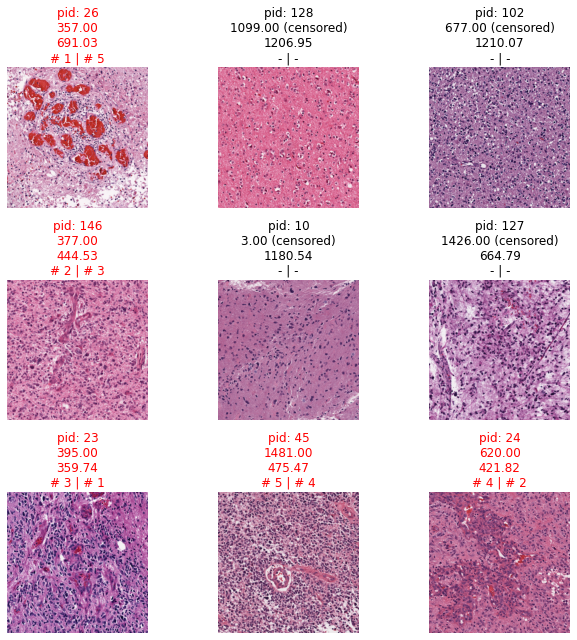

In [13]:
learn.show_results()
plt.tight_layout()